<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_3A_GEE_Harmonization_And_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

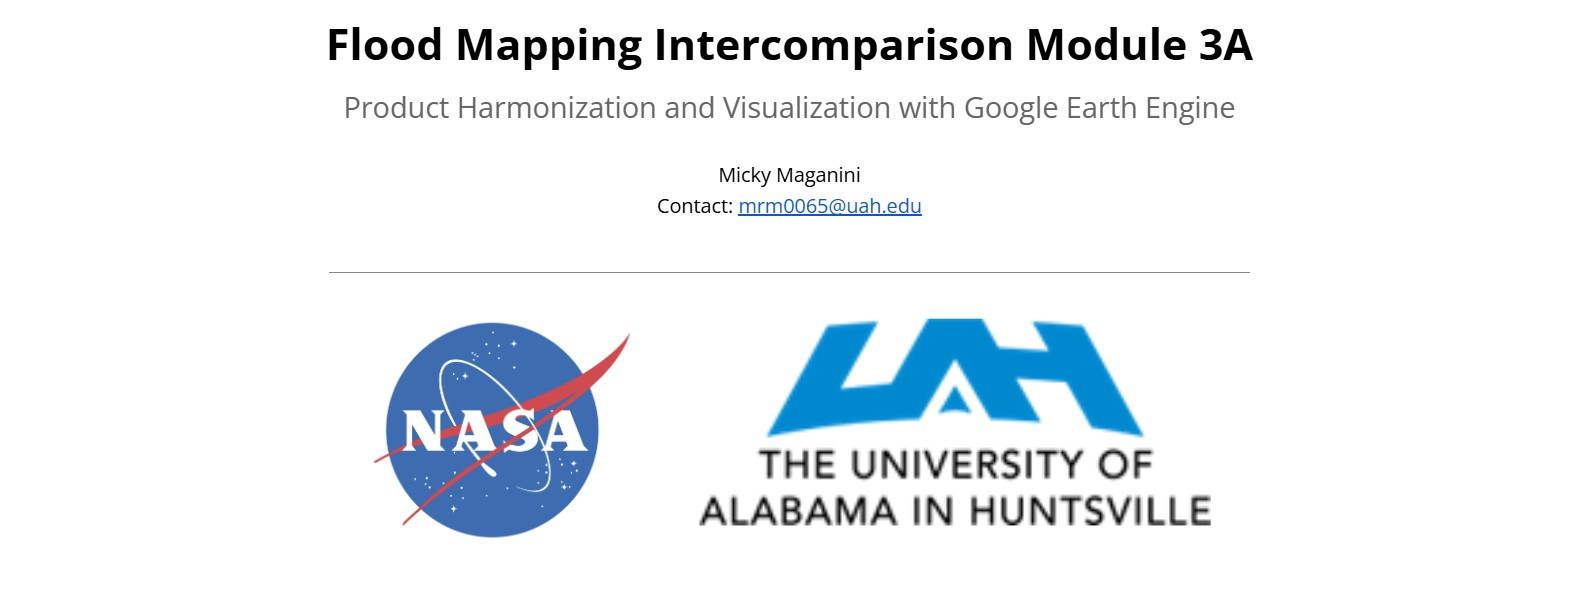

# Introduction

The goal of this module is to take the flood maps that we obtained from the global products, mosaic them, clip them, and assign to them all common raster values.

Each of the products has their own unique raster values, which can be seen in [this table](https://docs.google.com/spreadsheets/d/15igmiH1EHjtiyprgx6LnF78lvNh2scZSnlc12ySr0PQ/edit?usp=sharing). This script will take each product and reassign its raster values to the following raster value scheme:

Pixel Value            |        Land Cover Class
---                    | :---:
0                      |  Nonwater
1                      |  Water
2                      |  Masked (e.g. cloud, cloud shadow)

**Table 1: Pixel Values Used for SERVIR's Flood Mapping Intercomparison Project**

### MODIFIABLE VARIABLE ALERT

Change the variables below to match your Google Earth Engine project and the Google Earth Engine Folder where you uploaded the flood maps we exported at the end of Module 2.

In [ ]:
my_gee_project = 'servir-sco-assets'
my_gee_folder = "users/mickymags/cambodia_test/"

In [ ]:
import geemap
import ee

ee.Authenticate()
ee.Initialize(project=my_gee_project)

# Step 1: Import Imagery

Import all of our flood maps and get our area of interest

In [ ]:
dswx_hls_mos = ee.Image(my_gee_folder + 'dswxhls_mosaic')
dswx_s1_mos = ee.Image(my_gee_folder + 'dswxs1_mosaic')
gfm_mos = ee.Image(my_gee_folder + 'gfm_mosaic')
hydrafloods_mos = ee.Image(my_gee_folder + 'hydrafloods_mosaic')
hydrosar_mos = ee.Image(my_gee_folder + 'hydrosar_mosaic')
mcdwd_mos = ee.Image(my_gee_folder + 'mcdwd_mosaic')
vfm_mos = ee.Image(my_gee_folder + 'vfm_mosaic')

aoi = ee.FeatureCollection(my_gee_folder + 'aoi')

In [ ]:
my_projection = dswx_hls_mos.projection().getInfo()["crs"]
my_projection

In [ ]:
# Get the coordinates of the center of the AOI for mapping purposes
aoi_centroid = aoi.geometry().centroid()             # Get the center of the AOI
lon = aoi_centroid.coordinates().get(0).getInfo()    # Extract the longitude from the centroid
lat = aoi_centroid.coordinates().get(1).getInfo()    # Extract the latitude from the centroid

# Part 2: Harmonization

## Part 2.1 VFM Harmonization

In [ ]:
#############################################################################
#   Part 2: Create a function to reassign pixel values to our new schema    #
#############################################################################
# Define a function to transform VFM maps into common schema. This function takes an image as
#its input and outputs an image with the schema mentioned in Table 1
def vng_sch(image):

  ################ Get Water Pixels ####################

  # Raster Values of 15 indicate open water without water fraction retrieval
  # Raster Values of 99 indicate open normal water from a river, lake, reservoir or ocean
  # Raster Values of 100-200 idnicate water fractions of floodwater. We selected 50 as the percent threshold
  # to consider a pixel as water/nonwater. Thus, for the purposes of this study, we selected 150 as the threshold
  # above which pixels are considered as floodwater pixels.
  vfm_water = image.eq(15).Or(image.eq(99)).Or(image.gte(150))

  ############## Get Nonwater Pixels ########################

  # Part 1 will get pixels that have floodwater but have less than 50% of the pixel covered in floodwater
  # Raster Values of 16 indicate clear-sky bare land
  # Raster Values of 17 indicate clear-sky vegetation
  # Raster Values of 20 indicate snow cover
  # Raster Values of 27 indicate river/lake covered in ice
  # Raster values of 38 indicate supra-snow ice water, mixed ice and water, or ice in melting status
  pt1 = image.gte(100).And(image.lt(150))
  pt2 = image.eq(16).Or(image.eq(17)).Or(image.eq(20)).Or(image.eq(27)).Or(image.eq(38))
  vfm_nonwater = pt1.Or(pt2)

  ############## Get Pixels where we do not have clear observations #############

  # Values of 1 indicate bad data pixels
  # Values of 30 indicate pixels where there is cloud cover
  # Values of 50 indicate pixels that have shadows from clouds or terrain.
  vfm_mask = image.eq(1).Or(image.eq(30)).Or(image.eq(50))

  # This section of the
  #ones = ee.Image(1)   # Dummy Image where every pixel has a value of 1
  #zeros = ee.Image(0)  # Dummy Image where every pixel has a value of 0
  #twos = ee.Image(2)   # Dummy Image where every pixel has a value of 2

  # This section of the code will replace the VFM raster values with our classification schema (see Table 1).
  vfm_mod = image.where(vfm_nonwater, ee.Image(0))   # Replace Nonwater Pixels as found by this code with a value of 0   # zeros
  vfm_v2 = vfm_mod.where(vfm_water, ee.Image(1))     # Replace Water Pixels as found by this code with a value of 1    # ones
  vfm_v3 = vfm_v2.where(vfm_mask, ee.Image(2))       # Replace Mask Pixels as found by this code with a value of 2    # twos

  return ee.Image(vfm_v3)

#################################################
#   Part 3: Apply our function from Part 2      #
#################################################
# Apply the dswx_sch function to our clipped dswx mosaic to the schema
# shown in table 1.
# Run the function on the mosaic
vfm_final = ee.Image(vng_sch(vfm_mos)).clip(aoi)

#Part 2.2 GFM Harmonization

In [ ]:
# We want to assign the pixels that were masked in the GFM image to have a value of 2.
def gfm_sch(image):
  twos = ee.Image(2)                   # Create an image where all pixels have a value of 2
  masked = image.gte(2)                # find the areas in the GFM image that have a pixel value greater than or equal to 2
  gfm_fin = image.where(masked, twos)
  return gfm_fin

# Mosaic the individual GFM images and clip the mosaic to the area of interest
gfm_final = gfm_sch(gfm_mos).clip(aoi)

#Part 2.3 MCDWD Harmonization


In [ ]:
#####################################################
#  Part 1: Mosaic MCDWD Images, Clip them to aoi    #
#####################################################
#mcdwd_mos = ee.ImageCollection([mcdwd1, mcdwd2, mcdwd3]).mosaic().clip(aoi)

#############################################################################
#   Part 2: Create a function to reassign pixel values to our new schema    #
#############################################################################
def mcdwd_sch(image):

  #image = image.unmask()

  ################ Get Water Pixels ####################

  # Pixel Values of 1 indicate regular surface water according to the MCDWD algorithm
  # Pixel Values of 2 indicate a recurring flood according to the MCDWD algorithm
  # Pixel values of 3 indicate floodwater according to the MCDWD algorithm
  mcdwd_water = image.eq(1).Or(image.eq(2)).Or(image.eq(3))

  ############## Get Nonwater Values ########################
  # Pixel values of 0 indicate no water is present according to the MCDWD algorithm
  mcdwd_nonwater = image.eq(0)

  ############## Get Pixels where we do not have clear observations #############
  # Pixel values of 255 indicate insufficient data
  #mcdwd_mask = image.mask()               # Get the mask of the MCDWD map
  #mcdwd_maskdata = mcdwd_mask.eq(0)       # Find values where the MCDWD mask is equal to 0
  #mcdwd_insufficient = image.eq(255)            # Get the MCDWD values with insufficient data
  #mcdwd_unclear = mcdwd_maskdata.Or(mcdwd_insufficient)

  # Replace MCDWD pixel values with our classification schema (see Table 1)
  #mcdwd_mod = image.where(mcdwd_nonwater, ee.Image(0))
  #mcdwd_v2 = mcdwd_mod.where(mcdwd_water, ee.Image(1))
  #mcdwd_v3 = mcdwd_v2.where(mcdwd_unclear, ee.Image(2))
  #mcdwd_v3 = image.where(mcdwd_maskdata, ee.Image(2))

  mcdwd_mask = image.mask().clip(aoi)
  mcdwd_maskdata = mcdwd_mask.eq(0)
  mcdwd_insufficient = image.unmask().eq(255)
  mcdwd_unclear = mcdwd_maskdata.Or(mcdwd_insufficient)

  #mcdwd_v3 = image.unmask().where(mcdwd_maskdata, ee.Image(2))
  mcdwd_v0 = image.unmask()
  mcdwd_v1 = mcdwd_v0.where(mcdwd_nonwater, ee.Image(0))
  mcdwd_v2 = mcdwd_v1.where(mcdwd_water, ee.Image(1))
  mcdwd_v3 = mcdwd_v2.where(mcdwd_unclear, ee.Image(2))
  mcdwd_v4 = mcdwd_v3.clip(aoi)

  #return mcdwd_v3#.clip(aoi)
  return mcdwd_v4

#################################################
#   Part 3: Apply our function from Part 2      #
#################################################
# Apply the mcdwd_sch function to our clipped dswx mosaic to the schema
# shown in table 1.
mcdwd_final = mcdwd_sch(mcdwd_mos).clip(aoi)

# Part 2.4 DSWx-HLS Harmonization

In [ ]:

#####################################################
#   Part 1: Mosaic DSWx Images, Clip them to aoi    #
#####################################################
#dswx_mos = ee.ImageCollection([dswx1, dswx2]).mosaic().clip(aoi)

##############################################################################
#   Part 2: Create a function to Reassign pixel values to our new schema     #
##############################################################################
def dswx_hls_sch(image):

  ################ Get Water Pixels ####################
  # Find Areas in DSWx that are water
  # Pixel Values of 1 are water.
  # Pixel Values of 254 are ocean masked
  dswx_water = image.eq(1).Or(image.eq(254))

  ############### Get Nonwater Pixels ########################

  # Pixel values of 0 are nonwater according to dswx
  # Pixel values of 252 are snow or ice according to dswx
  # Pixel values of 2 are partial surface water according to dswx wte
  dswx_nonwater = image.eq(0).Or(image.eq(252)).Or(image.eq(2))

  ############## Get Pixels where we do not have clear observations #############
  # Pixel Values of 255 are Fill Values according to dswx
  # Pixel Values of 253 are associated with clouds or cloud shadows
  dswx_mask = image.eq(255).Or(image.eq(253))

  # Assign pixel values of 0 to areas classified as nonwater by dswx,
  # pixel values of 1 to areas classified as water by dswx, and pixel
  # values of 2 to areas classified as neither water nor nonwater by dswx.
  dswx_mod = image.where(dswx_nonwater, ee.Image(0))
  dswx_v2 = dswx_mod.where(dswx_water, ee.Image(1))
  dswx_v3 = dswx_v2.where(dswx_mask, ee.Image(2))

  # The output of this function will be the reclassified image.
  return dswx_v3

#################################################
#   Part 3: Apply our function from Part 2      #
#################################################
# Apply the dswx_sch function to our clipped dswx mosaic to the schema
# shown in table 1.
#dswx_hls_final = dswx_hls_sch(dswx_hls_mos).clip(aoi)
dswx_hls_final = dswx_hls_sch(dswx_hls_mos).clip(aoi)

# Part 2.5: DSWx-S1 Harmonization

In [ ]:
# Part 1: Create a function to reassign pixel values to our new schema
def dswx_s1_sch(image):
  ############## Get water Pixels ####################
  # Find areas of DSWx-S1 that are water
  # Pixel values of 1 are water
  dswx_s1_water = image.eq(1)

  ################ Get Nonwater Pixels ###############
  # Find areas of DSWx-S1 that are nonwater
  # Pixel values of 0 are not water.
  # Pixel values of 250 are areas where the height above nearest drainage is higher than the
  # threshold set by the DSWx-s1 developers, so they are assumed to be nonwater as it would be illogical
  # for water to be found at such a height above the nearest drainage
  dswx_s1_nonwater = image.eq(0).Or(image.eq(250))

  ################### Get Pixels where we do not have clear observations #################
  # Pixel values of 251 are layover or shadow masked
  # Pixel values of 255 are no data, or fill, values
  dswx_s1_mask = image.eq(251).Or(image.eq(255))

  # Assign pixel values of 0 to areas classified as nonwater by DSWx-S1
  # Assign pixel values of 1 to areas classified as water by DSWx-S1
  # Assign pixel values of 2 to areas classified as neither water nor nonwater by DSWx-S1
  dswx_s1_mod = image.where(dswx_s1_nonwater, ee.Image(0))
  dswx_s1_v2 = dswx_s1_mod.where(dswx_s1_water, ee.Image(1))
  dswx_s1_v3 = dswx_s1_v2.where(dswx_s1_mask, ee.Image(2))

  # The output of this function will be the reclassified image.
  return dswx_s1_v3

# Part 2: Apply the function from part 3 to our clipped DSWx-S1 mosaic
dswxs1_final = dswx_s1_sch(dswx_s1_mos).clip(aoi)

# Part 2.6 HYDRAFLOODS HARMONIZATION

In [ ]:
def hf_sch(image):

  # Get image mask
  unmsked_img = image.unmask()
  hf_mask = image.mask()
  hf_masked = hf_mask.lt(1) #hf_mask.eq(0)

  hf_mod = unmsked_img.where(hf_masked, ee.Image(2))
  hf_v3 = hf_mod.clip(aoi)

  return hf_v3

hf_final = hf_sch(hydrafloods_mos).clip(aoi)

# Part 2.7: HYDROSAR Harmonization



In [ ]:
def hydrosar_sch(img):
  # Get image mask
  unmsked_img = img.unmask()
  hydrosar_mask = img.mask()
  hydrosar_masked = hydrosar_mask.lt(1)

  hydrosar_mod = unmsked_img.where(hydrosar_masked, ee.Image(2))
  hydrosar_v3 = hydrosar_mod.clip(aoi)

  return hydrosar_v3

hydrosar_final = hydrosar_sch(hydrosar_mos).clip(aoi)

# Part 3: Map Visualization

Let's Visualize the Flood Maps to get a general idea of how they perform when compared with each other.

In [ ]:
vp = {
    'min': 0,
    'max': 2,
    'palette': ['000000', 'add8e6', 'FFFFFF']
}

Map = geemap.Map(center = (lat, lon), zoom = 5)
Map.addLayer(aoi, {}, 'Area of Interest')
Map.addLayer(vfm_final, vp, 'VIIRS Flood Map')
Map.addLayer(mcdwd_final, vp, 'MCDWD Flood Map')
Map.addLayer(gfm_final, vp, 'GFM Map')
Map.addLayer(dswx_hls_final, vp, 'DSWx-HLS Flood Map')
Map.addLayer(dswxs1_final, vp, 'DSWX-S1 Flood Map')
Map.addLayer(hf_final, vp, 'HYDRAFloods ')
Map.addLayer(hydrosar_final, vp, 'HYDROSAR')

Map.addLayerControl()
Map

# Part 4: Export the Mosaicked Flood Maps with new Raster Values

Now we will Export our new images to Google Earth Engine images so we can use them later.

In [ ]:
# Define a function that exports an Image to a Google Earth Engine Asset.
def exporter(img, asset_id, scale_):

  desc = 'Flood_Map_Export_'
  region_ = aoi.geometry()
  geemap.ee_export_image_to_asset(image = img,
                                  assetId = asset_id,
                                  description = desc,
                                  region = region_,
                                  crs = my_projection,
                                  scale = scale_,
                                  maxPixels = 1e13)
  return 0

In [ ]:
# Get the scales of the product
vfm_scale = vfm_final.projection().nominalScale().getInfo()
mcdwd_scale = mcdwd_final.projection().nominalScale().getInfo()
dswxhls_scale = dswx_hls_final.projection().nominalScale().getInfo()
dswxs1_scale = dswxs1_final.projection().nominalScale().getInfo()
hydrafloods_scale = hf_final.projection().nominalScale().getInfo()
hydrosar_scale = hydrosar_final.projection().nominalScale().getInfo()
gfm_scale = gfm_final.projection().nominalScale().getInfo()

In [ ]:
# Export VFM
vfm_aid_final_30 = my_gee_folder + 'vfm_harmonized'
exporter(vfm_final, vfm_aid_final_30, vfm_scale)

# Export GFM
gfm_aid_final = my_gee_folder + 'gfm_harmonized'
exporter(gfm_final, gfm_aid_final, gfm_scale)

# Export MCDWD
mcdwd_aid_final_30 = my_gee_folder + 'mcdwd_harmonized'
exporter(mcdwd_final, mcdwd_aid_final_30, mcdwd_scale)

# Export DSWx-HLS
dswxhls_aid_final_30 = my_gee_folder + 'dswxhls_harmonized'
exporter(dswx_hls_final, dswxhls_aid_final_30, dswxhls_scale)

# Export DSWx-S1
dswxs1_aid_final_30 = my_gee_folder + 'dswxs1_harmonized'
exporter(dswxs1_final, dswxs1_aid_final_30, dswxs1_scale)

# Export Hydrosar
hydrosar_aid_final = my_gee_folder + 'hydrosar_harmonized'
exporter(hydrosar_final, hydrosar_aid_final, hydrosar_scale)

# Export HYDRAFloods
hydrafloods_aid_final = my_gee_folder + 'hydrafloods_harmonized'
exporter(hf_final, hydrafloods_aid_final, hydrafloods_scale)

The above cell will return a 0, but your exports have begun. Click [here](https://code.earthengine.google.com/) to open the GEE Code Editor Interface. Navigate to the Tasks tab by clicking on the right tab. These will take a couple minutes to an hour to run depending on the size of your study area.